In [1]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="0XyC6GWdsX9dgNagE50c")
project = rf.workspace("ey-storm-damage").project("storm-damage-nkyfj")
version = project.version(8)
dataset = version.download("yolov8")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.1/74.1 kB 1.3 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.3/158.3 kB 2.8 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 30.2 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.9.0.80
    Uninstalling opencv-python-headless-4.9.0.80:
      Successfully uninstalled opencv-python-headless-4.9.0.80
  Attempting uninstall: idna
    Found existing installation: idna 3.6
    Uninstalling idna-3.6:
      Successfully uninstalled idna-3.6
  Attempting uninstall: cycler
    Found existing installation: cycler 0.12.1
    Uninstalling cycler-0.12.1:
      Successfully uninstalled cycler-0.12.1
  Attempting uninstall: certifi
    Found existing install


Extracting Dataset Version Zip to Storm-Damage-8 in yolov8:: 100%|██████████| 774/774 [00:00<00:00, 7452.98it/s]


In [4]:
# Import model
%pip install ultralytics
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.5 kB 557.8 kB/s eta 0:00:00 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 750.8/750.8 kB 1.7 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [5]:
# Importing the required libraries
from ultralytics import YOLO
import squarify
import matplotlib.pyplot as plt
import cv2
import os
import random
import pandas as pd
import numpy as np
import matplotlib.image as mpimg
import seaborn as sns
import yaml
import io
import torch
from PIL import Image
from torchvision import transforms
import shutil

sns.set_style('darkgrid')

%matplotlib inline

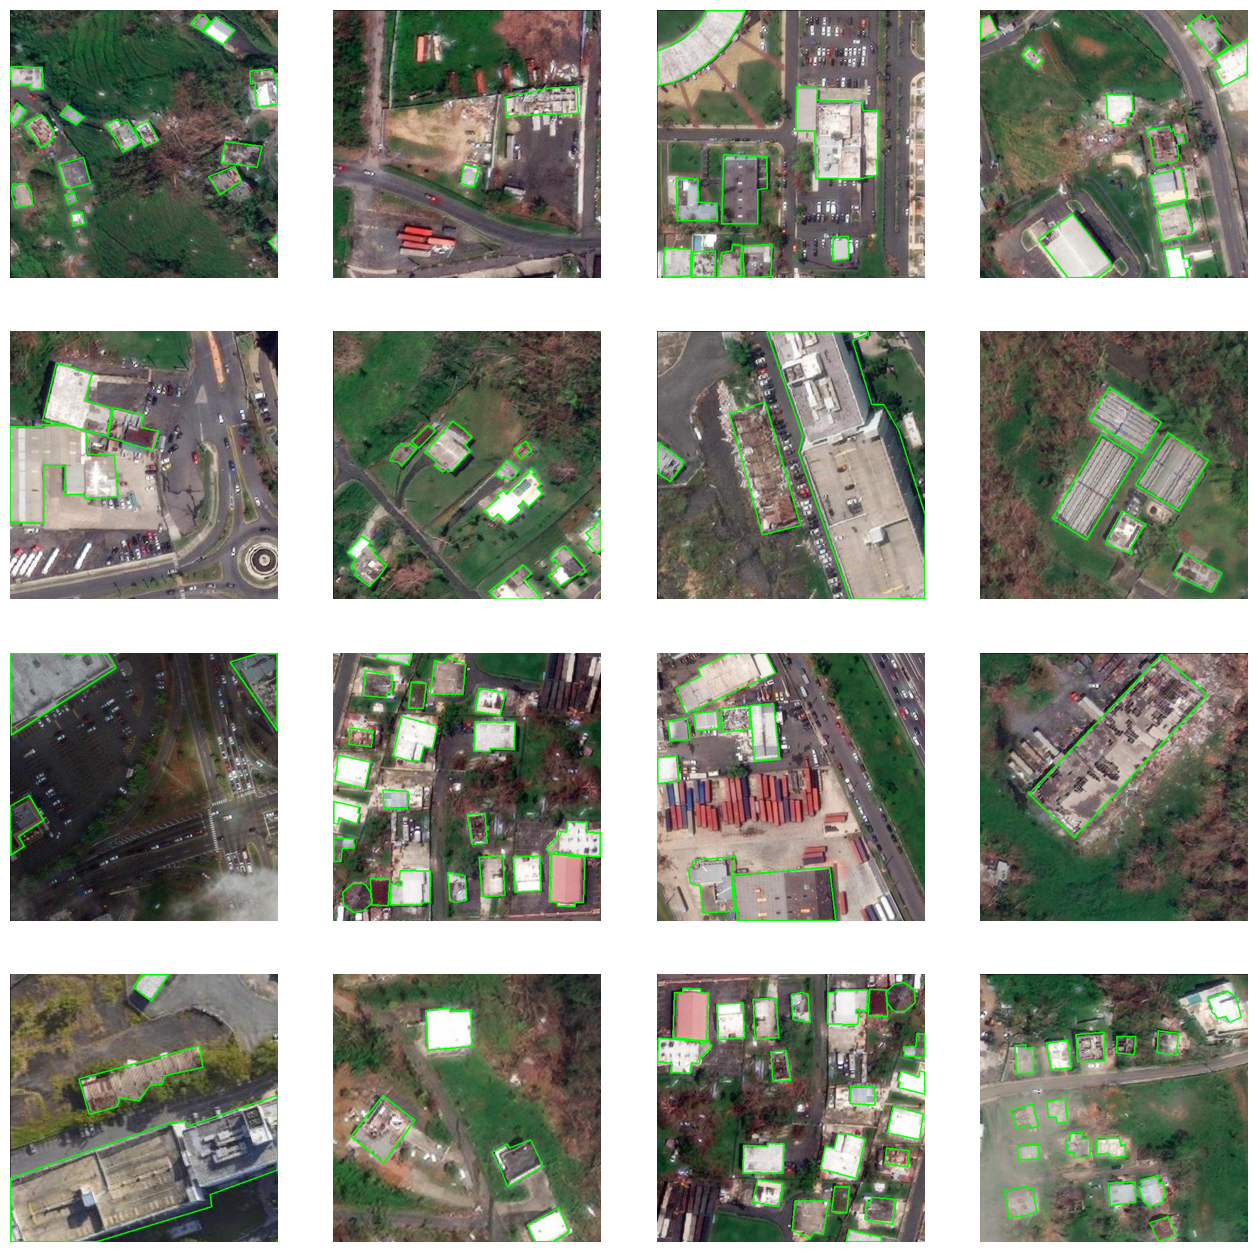

In [4]:
# Define the paths to the images and labels directories
train_images = "/kaggle/working/Storm-Damage-8/train/images"
train_labels = "/kaggle/working/Storm-Damage-8/train/labels"

test_images = "/kaggle/working/Storm-Damage-8/test/images"
test_labels = "/kaggle/working/Storm-Damage-8/test/labels"

val_images = "/kaggle/working/Storm-Damage-8/valid/images"
val_labels = "/kaggle/working/Storm-Damage-8/valid/labels"

# Get a list of all the image files in the training images directory
image_files = os.listdir(train_images)

# Choose 16 random image files from the list
random_images = random.sample(image_files, 16)

# Set up the plot
fig, axs = plt.subplots(4, 4, figsize=(16, 16))

# Loop over the random images and plot the object detections
for i, image_file in enumerate(random_images):
    row = i // 4
    col = i % 4

    # Load the image
    image_path = os.path.join(train_images, image_file)
    image = cv2.imread(image_path)

    # Load the labels for this image
    label_file = os.path.splitext(image_file)[0] + ".txt"
    label_path = os.path.join(train_labels, label_file)
    with open(label_path, "r") as f:
        labels = f.read().strip().split("\n")

    # Loop over the labels and plot the polygon detections
    for label in labels:
        parts = list(map(float, label.split()))
        if len(parts) < 3:  # Skip invalid labels
            continue
        # Assuming class_id followed by pairs of x, y for vertices
        vertices = [(int(parts[j] * image.shape[1]), int(parts[j + 1] * image.shape[0])) for j in range(1, len(parts), 2)]
        vertices_np = np.array(vertices, np.int32)
        vertices_np = vertices_np.reshape((-1, 1, 2))
        cv2.polylines(image, [vertices_np], isClosed=True, color=(0, 255, 0), thickness=2)

    # Show the image with the object detections
    axs[row, col].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    axs[row, col].axis('off')

plt.show()

#### Labels:
##### 0: Damaged Commercial Building
##### 1: Damaged Residential Building
##### 2: Undamaged Commercial Building
##### 3: Undamaged Residential Building

In [5]:
bda_dir = '/kaggle/working/Storm-Damage-8/bda'
btc_dir = '/kaggle/working/Storm-Damage-8/btc'

# Remove if these are files
if not os.path.isdir(bda_dir) and os.path.exists(bda_dir):
    os.remove(bda_dir)
if not os.path.isdir(btc_dir) and os.path.exists(btc_dir):
    os.remove(btc_dir)

# Ensure directories exist
os.makedirs(bda_dir, exist_ok=True)
os.makedirs(btc_dir, exist_ok=True)

In [6]:
# Base directory
base_dir = '/kaggle/working/Storm-Damage-8/'

# Operations for 'bda'
shutil.copy(os.path.join(base_dir, 'data.yaml'), os.path.join(bda_dir, 'data_bda.yaml'))
for folder in ['train', 'test', 'valid']:
    src = os.path.join(base_dir, folder)
    dst = os.path.join(bda_dir, folder + '_bda')
    shutil.copytree(src, dst)

# Operations for 'btc'
shutil.copy(os.path.join(base_dir, 'data.yaml'), os.path.join(btc_dir, 'data_btc.yaml'))
for folder in ['train', 'test', 'valid']:
    src = os.path.join(base_dir, folder)
    dst = os.path.join(btc_dir, folder + '_btc')
    shutil.copytree(src, dst)

In [7]:
# Load an image using OpenCV
image = cv2.imread("/kaggle/working/Storm-Damage-8/train/images/Pre_Event_019_jpg.rf.bb77b85c4de16be54881e512f9fbda24.jpg")

# Get the size of the image
height, width, channels = image.shape
print(f"The image has dimensions {width}x{height} and {channels} channels.")

The image has dimensions 512x512 and 3 channels.


In [8]:
dirs_bda = {
    'train': '/kaggle/working/Storm-Damage-8/bda/train_bda/labels/',
    'test': '/kaggle/working/Storm-Damage-8/bda/test_bda/labels/',
    'valid': '/kaggle/working/Storm-Damage-8/bda/valid_bda/labels/'
}

# Modify class IDs for BDA
def modify_for_bda(class_id):
    if class_id in [0, 1]:  # Damaged
        return '0'
    elif class_id in [2, 3]:  # Undamaged
        return '1'

# Process each directory
def process_directory(directory):
    for filename in os.listdir(directory):
        if filename.endswith(".txt"):  # Assuming text files for YOLO format
            filepath = os.path.join(directory, filename)
            with open(filepath, 'r') as file:
                lines = file.readlines()
            with open(filepath, 'w') as file:
                for line in lines:
                    parts = line.split()
                    if parts:
                        original_class_id = int(parts[0])
                        new_class_id = modify_for_bda(original_class_id)
                        parts[0] = new_class_id 
                        new_line = ' '.join(parts) + '\n'
                        file.write(new_line)
                    else:
                        file.write(line)

# Apply modifications for each set
for key, directory in dirs_bda.items():
    process_directory(directory)
    
print("Modification successfully.")

Modification successfully.


In [9]:
dirs_btc = {
    'train': '/kaggle/working/Storm-Damage-8/btc/train_btc/labels/',
    'test': '/kaggle/working/Storm-Damage-8/btc/test_btc/labels/',
    'valid': '/kaggle/working/Storm-Damage-8/btc/valid_btc/labels/'
}

# Modify class IDs for BTC
def modify_for_btc(class_id):
    if class_id in [0, 2]:  # Commercial
        return '0'
    elif class_id in [1, 3]:  # Residential
        return '1'

# Process each directory
def process_directory(directory):
    for filename in os.listdir(directory):
        if filename.endswith(".txt"):  # Assuming text files for YOLO format
            filepath = os.path.join(directory, filename)
            with open(filepath, 'r') as file:
                lines = file.readlines()
            with open(filepath, 'w') as file:
                for line in lines:
                    parts = line.split()
                    if parts: 
                        original_class_id = int(parts[0])
                        new_class_id = modify_for_btc(original_class_id)
                        parts[0] = new_class_id 
                        new_line = ' '.join(parts) + '\n'
                        file.write(new_line)
                    else:
                        file.write(line)

# Apply modifications for each set
for key, directory in dirs_btc.items():
    process_directory(directory)
    
print("Modification successfully.")

Modification successfully.


In [10]:
with open("/kaggle/working/Storm-Damage-8/data.yaml") as stream:
    try:
        print(yaml.safe_load(stream))
    except yaml.YAMLError as exc:
        print(exc)

{'names': ['Damaged Commercial Building', 'Damaged Residential Building', 'Undamaged Commercial Building', 'Undamaged Residential Building'], 'nc': 4, 'roboflow': {'license': 'Public Domain', 'project': 'storm-damage-nkyfj', 'url': 'https://universe.roboflow.com/ey-storm-damage/storm-damage-nkyfj/dataset/8', 'version': 8, 'workspace': 'ey-storm-damage'}, 'test': '../test/images', 'train': 'Storm-Damage-8/train/images', 'val': 'Storm-Damage-8/valid/images'}


In [11]:
with open("/kaggle/working/Storm-Damage-8/bda/data_bda.yaml") as stream:
    try:
        print(yaml.safe_load(stream))
    except yaml.YAMLError as exc:
        print(exc)

{'names': ['Damaged Commercial Building', 'Damaged Residential Building', 'Undamaged Commercial Building', 'Undamaged Residential Building'], 'nc': 4, 'roboflow': {'license': 'Public Domain', 'project': 'storm-damage-nkyfj', 'url': 'https://universe.roboflow.com/ey-storm-damage/storm-damage-nkyfj/dataset/8', 'version': 8, 'workspace': 'ey-storm-damage'}, 'test': '../test/images', 'train': 'Storm-Damage-8/train/images', 'val': 'Storm-Damage-8/valid/images'}


In [12]:
with open("/kaggle/working/Storm-Damage-8/btc/data_btc.yaml") as stream:
    try:
        print(yaml.safe_load(stream))
    except yaml.YAMLError as exc:
        print(exc)

{'names': ['Damaged Commercial Building', 'Damaged Residential Building', 'Undamaged Commercial Building', 'Undamaged Residential Building'], 'nc': 4, 'roboflow': {'license': 'Public Domain', 'project': 'storm-damage-nkyfj', 'url': 'https://universe.roboflow.com/ey-storm-damage/storm-damage-nkyfj/dataset/8', 'version': 8, 'workspace': 'ey-storm-damage'}, 'test': '../test/images', 'train': 'Storm-Damage-8/train/images', 'val': 'Storm-Damage-8/valid/images'}


In [13]:
def update_yaml(file_path, class_names, num_classes):
    with open(file_path, 'r') as file:
        data = yaml.safe_load(file)  # Load existing data

    # Update the class names and number of classes
    data['names'] = class_names
    data['nc'] = num_classes

    # Write the updated data back to the file
    with open(file_path, 'w') as file:
        yaml.safe_dump(data, file, default_flow_style=False)

# Paths to the YAML files
bda_yaml_path = '/kaggle/working/Storm-Damage-8/bda/data_bda.yaml'
btc_yaml_path = '/kaggle/working/Storm-Damage-8/btc/data_btc.yaml'

# Update BDA YAML
update_yaml(bda_yaml_path, ['Damaged', 'Undamaged'], 2)

# Update BTC YAML
update_yaml(btc_yaml_path, ['Commercial', 'Residential'], 2)

In [14]:
# Define data
data_yaml_bda = {
    'names': ['Damaged', 'Undamaged'],
    'nc': 2,
    'train': '/kaggle/working/Storm-Damage-8/bda/train_bda/images',
    'val': '/kaggle/working/Storm-Damage-8/bda/valid_bda/images',
    'test': '/kaggle/working/Storm-Damage-8/bda/test_bda/images',
}

# Write YAML file
with io.open('/kaggle/working/Storm-Damage-8/bda/data_bda.yaml', 'w', encoding='utf8') as outfile:
    yaml.dump(data_yaml_bda, outfile, default_flow_style=False, allow_unicode=True)

# Read YAML file
with open("/kaggle/working/Storm-Damage-8/bda/data_bda.yaml", 'r') as stream:
    data_loaded = yaml.safe_load(stream)

In [15]:
# Verify .yaml file
with open("/kaggle/working/Storm-Damage-8/bda/data_bda.yaml") as stream:
    try:
        print(yaml.safe_load(stream))
    except yaml.YAMLError as exc:
        print(exc)

{'names': ['Damaged', 'Undamaged'], 'nc': 2, 'test': '/kaggle/working/Storm-Damage-8/bda/test_bda/images', 'train': '/kaggle/working/Storm-Damage-8/bda/train_bda/images', 'val': '/kaggle/working/Storm-Damage-8/bda/valid_bda/images'}


In [16]:
# Define data
data_yaml_btc = {
    'names': ['Commercial', 'Residential'],
    'nc': 2,
    'train': '/kaggle/working/Storm-Damage-8/btc/train_btc/images',
    'val': '/kaggle/working/Storm-Damage-8/btc/valid_btc/images',
    'test': '/kaggle/working/Storm-Damage-8/btc/test_btc/images',
}

# Write YAML file
with io.open('/kaggle/working/Storm-Damage-8/btc/data_btc.yaml', 'w', encoding='utf8') as outfile:
    yaml.dump(data_yaml_btc, outfile, default_flow_style=False, allow_unicode=True)

# Read YAML file
with open("/kaggle/working/Storm-Damage-8/btc/data_btc.yaml", 'r') as stream:
    data_loaded = yaml.safe_load(stream)

In [17]:
# Verify .yaml file
with open("/kaggle/working/Storm-Damage-8/btc/data_btc.yaml") as stream:
    try:
        print(yaml.safe_load(stream))
    except yaml.YAMLError as exc:
        print(exc)

{'names': ['Commercial', 'Residential'], 'nc': 2, 'test': '/kaggle/working/Storm-Damage-8/btc/test_btc/images', 'train': '/kaggle/working/Storm-Damage-8/btc/train_btc/images', 'val': '/kaggle/working/Storm-Damage-8/btc/valid_btc/images'}


# BDA

In [18]:
os.chdir('/kaggle/working/Storm-Damage-8/bda/')

# You can now proceed to run your training code
bda_model = YOLO('yolov8x.pt')

# Training the model
bda_model.train(data='/kaggle/working/Storm-Damage-8/bda/data_bda.yaml',
            epochs=20,
            imgsz=height,
            seed=42,
            batch=8,
            workers=4,
            save_dir=bda_dir)

100%|██████████| 131M/131M [00:00<00:00, 267MB/s]  


Ultralytics YOLOv8.1.47 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8x.pt, data=/kaggle/working/Storm-Damage-8/bda/data_bda.yaml, epochs=20, time=None, patience=100, batch=8, imgsz=512, save=True, save_period=-1, cache=False, device=None, workers=4, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=42, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_

100%|██████████| 755k/755k [00:00<00:00, 14.4MB/s]
2024-04-16 04:15:24,247	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-04-16 04:15:25,152	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-04-16 04:15:29.284950: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-16 04:15:29.285066: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-16 04:15:29.553938: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS facto

Overriding model.yaml nc=80 with nc=2

                   from  n    params  module                                       arguments                     
  0                  -1  1      2320  ultralytics.nn.modules.conv.Conv             [3, 80, 3, 2]                 
  1                  -1  1    115520  ultralytics.nn.modules.conv.Conv             [80, 160, 3, 2]               
  2                  -1  3    436800  ultralytics.nn.modules.block.C2f             [160, 160, 3, True]           
  3                  -1  1    461440  ultralytics.nn.modules.conv.Conv             [160, 320, 3, 2]              
  4                  -1  6   3281920  ultralytics.nn.modules.block.C2f             [320, 320, 6, True]           
  5                  -1  1   1844480  ultralytics.nn.modules.conv.Conv             [320, 640, 3, 2]              
  6                  -1  6  13117440  ultralytics.nn.modules.block.C2f             [640, 640, 6, True]           
  7                  -1  1   3687680  ultralytics

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...


100%|██████████| 6.23M/6.23M [00:00<00:00, 69.1MB/s]


AMP: checks passed ✅


train: Scanning /kaggle/working/Storm-Damage-8/bda/train_bda/labels... 361 images, 12 backgrounds, 0 corrupt: 100%|██████████| 361/361 [00:00<00:00, 885.78it/s]


train: New cache created: /kaggle/working/Storm-Damage-8/bda/train_bda/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /kaggle/working/Storm-Damage-8/bda/valid_bda/labels... 8 images, 1 backgrounds, 0 corrupt: 100%|██████████| 8/8 [00:00<00:00, 804.55it/s]

val: New cache created: /kaggle/working/Storm-Damage-8/bda/valid_bda/labels.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 97 weight(decay=0.0), 104 weight(decay=0.0005), 103 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 512 train, 512 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      6.06G      1.363      2.152      1.368          2        512: 100%|██████████| 46/46 [00:24<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.74s/it]

                   all          8        102     0.0305      0.624     0.0296     0.0158



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      6.46G      1.363      1.471      1.358          8        512: 100%|██████████| 46/46 [00:19<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.69it/s]

                   all          8        102     0.0194      0.428     0.0137    0.00697



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      6.46G      1.462      1.439      1.405         23        512: 100%|██████████| 46/46 [00:19<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.10it/s]

                   all          8        102    0.00108     0.0217   0.000587   0.000132



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20       6.4G      1.397      1.483      1.423          4        512: 100%|██████████| 46/46 [00:19<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.12it/s]

                   all          8        102      0.306      0.613       0.37      0.187



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      6.41G      1.406      1.392      1.424          6        512: 100%|██████████| 46/46 [00:19<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.06it/s]

                   all          8        102       0.15     0.0815     0.0655     0.0293



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      6.46G      1.308      1.317      1.369         19        512: 100%|██████████| 46/46 [00:19<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.11it/s]


                   all          8        102      0.336       0.12     0.0682     0.0318

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      6.48G      1.271      1.293      1.316         22        512: 100%|██████████| 46/46 [00:19<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.95it/s]

                   all          8        102      0.503     0.0272    0.00115   0.000546



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      6.47G      1.207      1.201      1.316         17        512: 100%|██████████| 46/46 [00:19<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.02it/s]

                   all          8        102      0.485      0.504      0.469      0.274



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      6.43G      1.187      1.106      1.289          7        512: 100%|██████████| 46/46 [00:19<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.36it/s]

                   all          8        102      0.705      0.544      0.678      0.378



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      6.47G      1.215        1.2       1.32          2        512: 100%|██████████| 46/46 [00:19<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.35it/s]

                   all          8        102      0.517      0.696      0.639      0.376


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      6.48G      1.174      1.135      1.318          6        512: 100%|██████████| 46/46 [00:19<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.03it/s]

                   all          8        102      0.746      0.589      0.678      0.386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      6.47G      1.124      1.038      1.307         22        512: 100%|██████████| 46/46 [00:18<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.03it/s]

                   all          8        102      0.673       0.72      0.751       0.43



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      6.45G       1.07     0.9855      1.266         13        512: 100%|██████████| 46/46 [00:18<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.94it/s]

                   all          8        102      0.713      0.706      0.728      0.391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      6.47G       1.09      1.013      1.284          8        512: 100%|██████████| 46/46 [00:18<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.27it/s]

                   all          8        102       0.57      0.671      0.666      0.357



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      6.51G      1.034     0.8987      1.224          7        512: 100%|██████████| 46/46 [00:18<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.24it/s]

                   all          8        102      0.803      0.591      0.707      0.399



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      6.51G      1.034     0.9156      1.227         20        512: 100%|██████████| 46/46 [00:18<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.29it/s]

                   all          8        102      0.803       0.69      0.771      0.462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      6.46G     0.9843     0.8058      1.209         14        512: 100%|██████████| 46/46 [00:18<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.20it/s]

                   all          8        102      0.645      0.636      0.709      0.431



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      6.49G     0.9473     0.8429      1.186          2        512: 100%|██████████| 46/46 [00:18<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.19it/s]

                   all          8        102      0.794      0.692      0.773      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      6.51G     0.9212     0.7681      1.169         10        512: 100%|██████████| 46/46 [00:18<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.11it/s]


                   all          8        102      0.765      0.702      0.799      0.495

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20       6.5G     0.9516     0.7938       1.19          1        512: 100%|██████████| 46/46 [00:18<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.22it/s]

                   all          8        102      0.837      0.717      0.821       0.49



20 epochs completed in 0.125 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 136.7MB
Optimizer stripped from runs/detect/train/weights/best.pt, 136.7MB

Validating runs/detect/train/weights/best.pt...
Ultralytics YOLOv8.1.47 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 268 layers, 68125494 parameters, 0 gradients, 257.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.22it/s]


                   all          8        102      0.761      0.702      0.799      0.495
               Damaged          8         10      0.649        0.6      0.659      0.354
             Undamaged          8         92      0.873      0.804      0.939      0.635
Speed: 0.2ms preprocess, 23.4ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to runs/detect/train


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7a73675dbeb0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04804

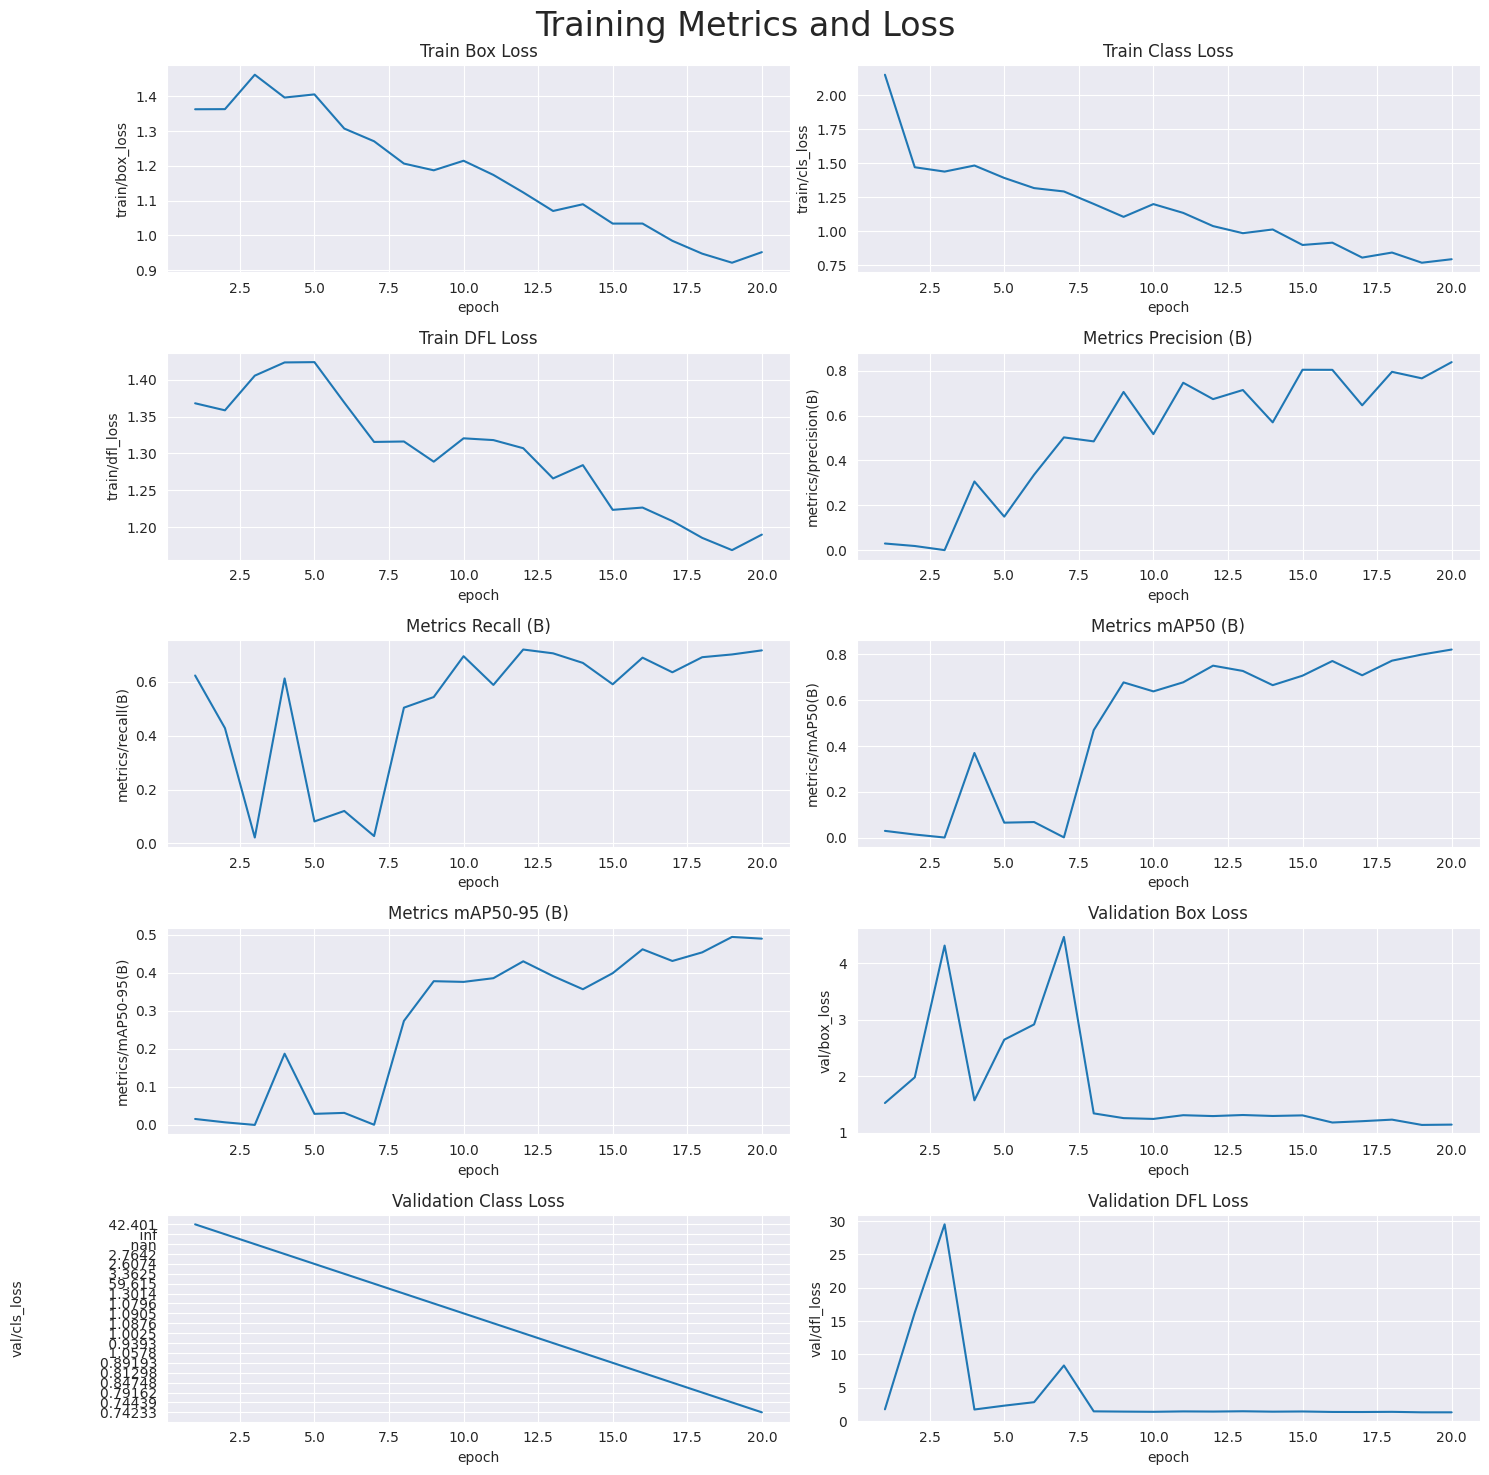

In [19]:
%matplotlib inline
# read in the results.csv file as a pandas dataframe
df = pd.read_csv('/kaggle/working/Storm-Damage-8/bda/runs/detect/train/results.csv')
df.columns = df.columns.str.strip()

# create subplots using seaborn
fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(15, 15))

# plot the columns using seaborn
sns.lineplot(x='epoch', y='train/box_loss', data=df, ax=axs[0,0])
sns.lineplot(x='epoch', y='train/cls_loss', data=df, ax=axs[0,1])
sns.lineplot(x='epoch', y='train/dfl_loss', data=df, ax=axs[1,0])
sns.lineplot(x='epoch', y='metrics/precision(B)', data=df, ax=axs[1,1])
sns.lineplot(x='epoch', y='metrics/recall(B)', data=df, ax=axs[2,0])
sns.lineplot(x='epoch', y='metrics/mAP50(B)', data=df, ax=axs[2,1])
sns.lineplot(x='epoch', y='metrics/mAP50-95(B)', data=df, ax=axs[3,0])
sns.lineplot(x='epoch', y='val/box_loss', data=df, ax=axs[3,1])
sns.lineplot(x='epoch', y='val/cls_loss', data=df, ax=axs[4,0])
sns.lineplot(x='epoch', y='val/dfl_loss', data=df, ax=axs[4,1])

# set titles and axis labels for each subplot
axs[0,0].set(title='Train Box Loss')
axs[0,1].set(title='Train Class Loss')
axs[1,0].set(title='Train DFL Loss')
axs[1,1].set(title='Metrics Precision (B)')
axs[2,0].set(title='Metrics Recall (B)')
axs[2,1].set(title='Metrics mAP50 (B)')
axs[3,0].set(title='Metrics mAP50-95 (B)')
axs[3,1].set(title='Validation Box Loss')
axs[4,0].set(title='Validation Class Loss')
axs[4,1].set(title='Validation DFL Loss')

# add suptitle and subheader
plt.suptitle('Training Metrics and Loss', fontsize=24)

# adjust top margin to make space for suptitle
plt.subplots_adjust(top=0.8)

# adjust spacing between subplots
plt.tight_layout()

plt.show()

In [20]:
%matplotlib inline
# Loading the best performing model
model = YOLO('/kaggle/working/Storm-Damage-8/bda/runs/detect/train/weights/best.pt')

# Evaluating the model on the test dataset
metrics = model.val(conf = 0.25, split = 'test')

Ultralytics YOLOv8.1.47 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 268 layers, 68125494 parameters, 0 gradients, 257.4 GFLOPs


val: Scanning /kaggle/working/Storm-Damage-8/bda/test_bda/labels... 12 images, 0 backgrounds, 0 corrupt: 100%|██████████| 12/12 [00:00<00:00, 762.47it/s]

val: New cache created: /kaggle/working/Storm-Damage-8/bda/test_bda/labels.cache



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.26it/s]


                   all         12        262      0.747      0.598      0.656      0.447
               Damaged         12         45      0.653      0.422      0.489      0.278
             Undamaged         12        217      0.841      0.774      0.823      0.615
Speed: 0.2ms preprocess, 47.9ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to runs/detect/val


In [21]:
# Function to perform ship detections
def building_detect(img_path):
    
    # Read the image
    img = cv2.imread(img_path)

    # Pass the image through the detection model and get the result
    detect_result = model(img)

    # Plot the detections
    detect_img = detect_result[0].plot()
    
    # Convert the image to RGB format
    detect_img = cv2.cvtColor(detect_img, cv2.COLOR_BGR2RGB)
    
    return detect_img


0: 512x512 3 Damageds, 29 Undamageds, 55.5ms
Speed: 1.8ms preprocess, 55.5ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 512)

0: 512x512 6 Damageds, 11 Undamageds, 55.6ms
Speed: 2.2ms preprocess, 55.6ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)

0: 512x512 4 Damageds, 11 Undamageds, 44.5ms
Speed: 1.6ms preprocess, 44.5ms inference, 1.3ms postprocess per image at shape (1, 3, 512, 512)

0: 512x512 2 Damageds, 27 Undamageds, 34.5ms
Speed: 1.7ms preprocess, 34.5ms inference, 1.3ms postprocess per image at shape (1, 3, 512, 512)

0: 512x512 2 Damageds, 10 Undamageds, 34.3ms
Speed: 1.6ms preprocess, 34.3ms inference, 1.2ms postprocess per image at shape (1, 3, 512, 512)

0: 512x512 29 Undamageds, 34.7ms
Speed: 1.6ms preprocess, 34.7ms inference, 1.4ms postprocess per image at shape (1, 3, 512, 512)

0: 512x512 5 Damageds, 32 Undamageds, 33.2ms
Speed: 1.6ms preprocess, 33.2ms inference, 1.2ms postprocess per image at shape (1, 3, 512, 512)

0: 512x512

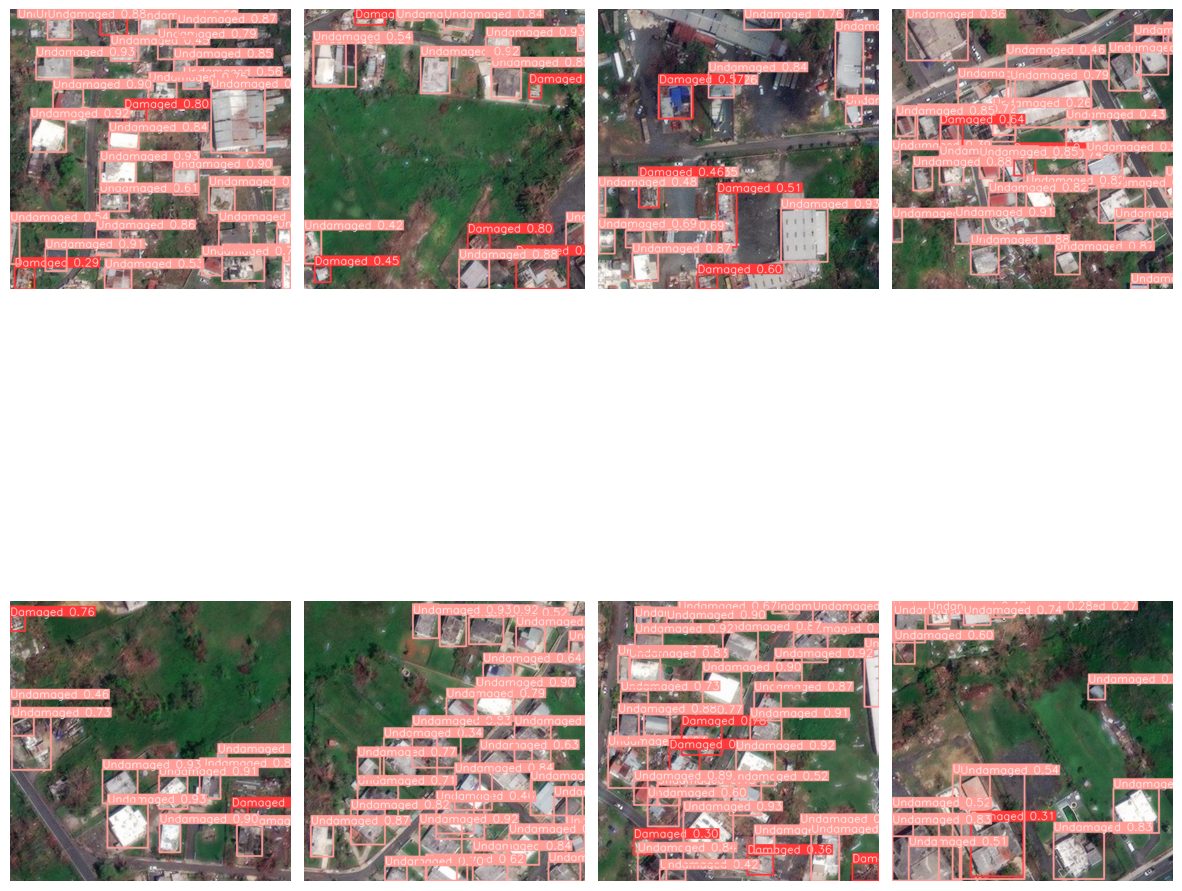

In [22]:
import random

# Define the directory where the custom images are stored
custom_image_dir = '/kaggle/working/Storm-Damage-8/bda/test_bda/images'

# Get the list of image files in the directory
image_files = os.listdir(custom_image_dir)

# Select 16 random images from the list
selected_images = random.sample(image_files, 8)

# Create a figure with subplots for each image
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(15, 15))

# Iterate over the selected images and plot each one
for i, img_file in enumerate(selected_images):
    
    # Compute the row and column index of the current subplot
    row_idx = i // 4
    col_idx = i % 4
    
    # Load the current image and run object detection
    img_path = os.path.join(custom_image_dir, img_file)
    detect_img = building_detect(img_path)
    
    # Plot the current image on the appropriate subplot
    axes[row_idx, col_idx].imshow(detect_img)
    axes[row_idx, col_idx].axis('off')

# Adjust the spacing between the subplots
plt.subplots_adjust(wspace=0.05, hspace=0.05)

# BTC

In [23]:
os.chdir('/kaggle/working/Storm-Damage-8/btc/')

# You can now proceed to run your training code
btc_model = YOLO('yolov8x.pt')

# Training the model
btc_model.train(data='/kaggle/working/Storm-Damage-8/btc/data_btc.yaml',
            epochs=20,
            imgsz=height,
            seed=42,
            batch=8,
            workers=4,
            save_dir=btc_dir)

100%|██████████| 131M/131M [00:00<00:00, 249MB/s]  


Ultralytics YOLOv8.1.47 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8x.pt, data=/kaggle/working/Storm-Damage-8/btc/data_btc.yaml, epochs=20, time=None, patience=100, batch=8, imgsz=512, save=True, save_period=-1, cache=False, device=None, workers=4, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=42, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_

wandb: Currently logged in as: maryle2002 (maryle). Use `wandb login --relogin` to force relogin


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...


100%|██████████| 6.23M/6.23M [00:00<00:00, 68.1MB/s]


AMP: checks passed ✅


train: Scanning /kaggle/working/Storm-Damage-8/btc/train_btc/labels... 361 images, 12 backgrounds, 0 corrupt: 100%|██████████| 361/361 [00:00<00:00, 769.41it/s]

train: New cache created: /kaggle/working/Storm-Damage-8/btc/train_btc/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/Storm-Damage-8/btc/valid_btc/labels... 8 images, 1 backgrounds, 0 corrupt: 100%|██████████| 8/8 [00:00<00:00, 5040.47it/s]

val: New cache created: /kaggle/working/Storm-Damage-8/btc/valid_btc/labels.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 97 weight(decay=0.0), 104 weight(decay=0.0005), 103 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 512 train, 512 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      9.67G      1.363      2.204      1.387          2        512: 100%|██████████| 46/46 [00:22<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.09it/s]

                   all          8        102     0.0743      0.246     0.0621     0.0397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      10.1G      1.367      1.611      1.392          8        512: 100%|██████████| 46/46 [00:20<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.41it/s]

                   all          8        102    0.00421     0.0407    0.00254   0.000757



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      10.1G      1.467      1.523      1.431         23        512: 100%|██████████| 46/46 [00:19<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.52it/s]

                   all          8        102     0.0213      0.315     0.0143    0.00781



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20        10G      1.424      1.697      1.451          4        512: 100%|██████████| 46/46 [00:19<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.79it/s]

                   all          8        102     0.0252      0.227     0.0133    0.00488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20        10G      1.343      1.444      1.412          6        512: 100%|██████████| 46/46 [00:19<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.26it/s]

                   all          8        102      0.421       0.35      0.297       0.17



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      10.1G      1.348      1.437      1.395         19        512: 100%|██████████| 46/46 [00:19<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.87it/s]

                   all          8        102      0.535      0.544      0.544      0.304



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      10.1G      1.276      1.367       1.33         22        512: 100%|██████████| 46/46 [00:19<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.09it/s]

                   all          8        102       0.41      0.411      0.413      0.242



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      10.1G      1.235      1.317      1.348         17        512: 100%|██████████| 46/46 [00:19<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.38it/s]

                   all          8        102      0.441      0.708      0.518      0.298



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      10.1G      1.204      1.196      1.305          7        512: 100%|██████████| 46/46 [00:19<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.73it/s]

                   all          8        102      0.719      0.661      0.738       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      10.1G      1.197      1.326      1.319          2        512: 100%|██████████| 46/46 [00:20<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.38it/s]

                   all          8        102      0.794      0.621      0.729      0.457


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      10.1G      1.207      1.241      1.346          6        512: 100%|██████████| 46/46 [00:19<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.10it/s]


                   all          8        102      0.711      0.708      0.768        0.5

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      10.1G      1.133      1.095      1.323         22        512: 100%|██████████| 46/46 [00:18<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.24it/s]

                   all          8        102      0.532      0.679      0.637      0.376



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      10.1G      1.106      1.063      1.298         13        512: 100%|██████████| 46/46 [00:18<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.14it/s]


                   all          8        102      0.754      0.585       0.72        0.4

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      10.1G      1.134      1.069      1.324          8        512: 100%|██████████| 46/46 [00:18<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.25it/s]

                   all          8        102       0.52      0.786      0.672      0.418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      10.1G      1.054     0.9697      1.244          7        512: 100%|██████████| 46/46 [00:18<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.20it/s]

                   all          8        102      0.623      0.726      0.716      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      10.1G      1.058      0.984      1.258         20        512: 100%|██████████| 46/46 [00:18<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.25it/s]

                   all          8        102      0.843      0.678      0.802      0.554



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      10.1G      1.008     0.9058      1.222         14        512: 100%|██████████| 46/46 [00:18<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.24it/s]

                   all          8        102      0.904      0.737      0.886      0.598



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      10.1G      0.979     0.8727      1.214          2        512: 100%|██████████| 46/46 [00:18<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.18it/s]

                   all          8        102      0.738      0.738       0.79      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      10.2G     0.9401     0.8193       1.19         10        512: 100%|██████████| 46/46 [00:18<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.85it/s]

                   all          8        102      0.716      0.745      0.832      0.555



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      10.1G     0.9504     0.8621      1.191          1        512: 100%|██████████| 46/46 [00:18<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.26it/s]

                   all          8        102      0.716      0.796      0.844      0.603



20 epochs completed in 0.124 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 136.7MB
Optimizer stripped from runs/detect/train/weights/best.pt, 136.7MB

Validating runs/detect/train/weights/best.pt...
Ultralytics YOLOv8.1.47 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 268 layers, 68125494 parameters, 0 gradients, 257.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.37it/s]


                   all          8        102      0.716      0.796      0.844      0.603
            Commercial          8         16      0.589      0.812      0.792      0.637
           Residential          8         86      0.842      0.779      0.896      0.568
Speed: 0.2ms preprocess, 21.6ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to runs/detect/train


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7a731850cb20>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04804

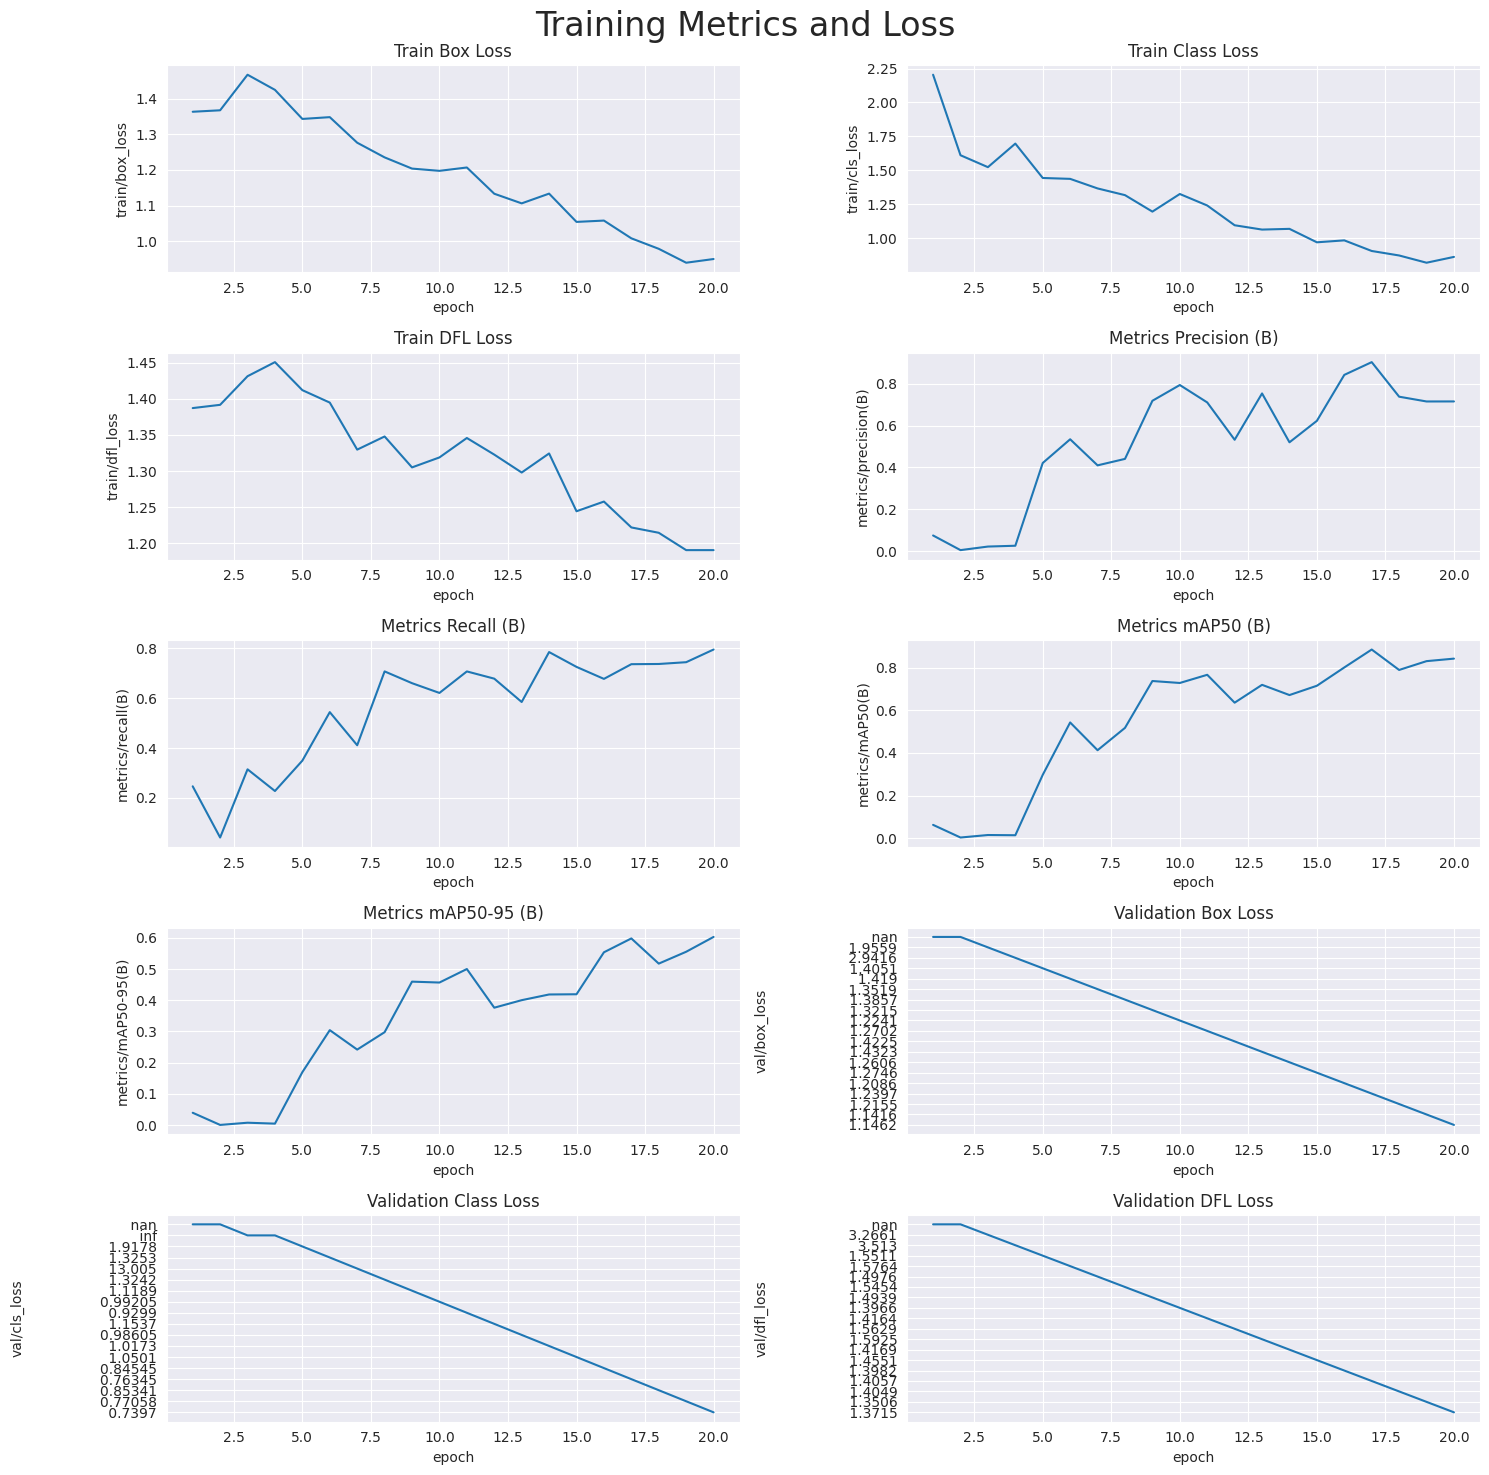

In [24]:
%matplotlib inline
# read in the results.csv file as a pandas dataframe
df = pd.read_csv('/kaggle/working/Storm-Damage-8/btc/runs/detect/train/results.csv')
df.columns = df.columns.str.strip()

# create subplots using seaborn
fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(15, 15))

# plot the columns using seaborn
sns.lineplot(x='epoch', y='train/box_loss', data=df, ax=axs[0,0])
sns.lineplot(x='epoch', y='train/cls_loss', data=df, ax=axs[0,1])
sns.lineplot(x='epoch', y='train/dfl_loss', data=df, ax=axs[1,0])
sns.lineplot(x='epoch', y='metrics/precision(B)', data=df, ax=axs[1,1])
sns.lineplot(x='epoch', y='metrics/recall(B)', data=df, ax=axs[2,0])
sns.lineplot(x='epoch', y='metrics/mAP50(B)', data=df, ax=axs[2,1])
sns.lineplot(x='epoch', y='metrics/mAP50-95(B)', data=df, ax=axs[3,0])
sns.lineplot(x='epoch', y='val/box_loss', data=df, ax=axs[3,1])
sns.lineplot(x='epoch', y='val/cls_loss', data=df, ax=axs[4,0])
sns.lineplot(x='epoch', y='val/dfl_loss', data=df, ax=axs[4,1])

# set titles and axis labels for each subplot
axs[0,0].set(title='Train Box Loss')
axs[0,1].set(title='Train Class Loss')
axs[1,0].set(title='Train DFL Loss')
axs[1,1].set(title='Metrics Precision (B)')
axs[2,0].set(title='Metrics Recall (B)')
axs[2,1].set(title='Metrics mAP50 (B)')
axs[3,0].set(title='Metrics mAP50-95 (B)')
axs[3,1].set(title='Validation Box Loss')
axs[4,0].set(title='Validation Class Loss')
axs[4,1].set(title='Validation DFL Loss')

# add suptitle and subheader
plt.suptitle('Training Metrics and Loss', fontsize=24)

# adjust top margin to make space for suptitle
plt.subplots_adjust(top=0.8)

# adjust spacing between subplots
plt.tight_layout()

plt.show()

In [25]:
%matplotlib inline
# Loading the best performing model
model = YOLO('/kaggle/working/Storm-Damage-8/btc/runs/detect/train/weights/best.pt')

# Evaluating the model on the test dataset
metrics = model.val(conf = 0.25, split = 'test')

Ultralytics YOLOv8.1.47 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 268 layers, 68125494 parameters, 0 gradients, 257.4 GFLOPs


val: Scanning /kaggle/working/Storm-Damage-8/btc/test_btc/labels... 12 images, 0 backgrounds, 0 corrupt: 100%|██████████| 12/12 [00:00<00:00, 681.40it/s]

val: New cache created: /kaggle/working/Storm-Damage-8/btc/test_btc/labels.cache



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.30it/s]


                   all         12        262      0.807      0.591      0.694      0.488
            Commercial         12         20      0.731       0.45       0.53      0.354
           Residential         12        242      0.883      0.731      0.859      0.623
Speed: 0.2ms preprocess, 44.5ms inference, 0.0ms loss, 3.8ms postprocess per image
Results saved to runs/detect/val


In [26]:
# Function to perform ship detections
def building_detect(img_path):
    
    # Read the image
    img = cv2.imread(img_path)

    # Pass the image through the detection model and get the result
    detect_result = model(img)

    # Plot the detections
    detect_img = detect_result[0].plot()
    
    # Convert the image to RGB format
    detect_img = cv2.cvtColor(detect_img, cv2.COLOR_BGR2RGB)
    
    return detect_img

In [ ]:
import random
import os
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont

# Define the directory where the custom images are stored
custom_image_dir = '/kaggle/working/Storm-Damage-8/btc/test_btc/images'

# Get the list of image files in the directory
image_files = os.listdir(custom_image_dir)

# Select 16 random images from the list
selected_images = random.sample(image_files, 8)

# Define colors for each class
colors = {0: ('#FFFF00', '#000000'),  # bright yellow box, black text
          1: ('#FFA500', '#000000')}  # bright orange box, black text

# Define the building_detect function
def building_detect(img_path):
    # Load the image
    image = Image.open(img_path)
    draw = ImageDraw.Draw(image)
    # Example detections (replace this with your actual detection logic)
    detections = [{'bbox': [50, 50, 200, 200], 'label': 0},
                  {'bbox': [250, 250, 400, 400], 'label': 1}]
    # Draw each detection
    for det in detections:
        color, text_color = colors[det['label']]
        bbox = det['bbox']
        draw.rectangle(bbox, outline=color, width=3)
        draw.text((bbox[0], bbox[1]-10), f'Class {det["label"]}', fill=color, font=ImageFont.load_default())
    return image

# Create a figure with subplots for each image
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(15, 15))

# Iterate over the selected images and plot each one
for i, img_file in enumerate(selected_images):
    # Compute the row and column index of the current subplot
    row_idx = i // 4
    col_idx = i % 4
    
    # Load the current image and run object detection
    img_path = os.path.join(custom_image_dir, img_file)
    detect_img = building_detect(img_path)
    
    # Plot the current image on the appropriate subplot
    axes[row_idx, col_idx].imshow(detect_img)
    axes[row_idx, col_idx].axis('off')

# Adjust the spacing between the subplots
plt.subplots_adjust(wspace=0.05, hspace=0.05)
plt.show()


# Sequential Processing

In [84]:
bda_model = YOLO('/kaggle/working/Storm-Damage-8/bda/runs/detect/train/weights/best.pt')
btc_model = YOLO('/kaggle/working/Storm-Damage-8/btc/runs/detect/train/weights/best.pt')

In [85]:
bda_metrics = bda_model.val(conf=0.25, split='test')
btc_metrics = btc_model.val(conf=0.25, split='test')

Ultralytics YOLOv8.2.0 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 268 layers, 68125494 parameters, 0 gradients, 257.4 GFLOPs


val: Scanning /kaggle/working/Storm-Damage-8/bda/test_bda/labels.cache... 12 images, 0 backgrounds, 0 corrupt: 100%|██████████| 12/12 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.30it/s]


                   all         12        262      0.747      0.598      0.656      0.447
               Damaged         12         45      0.653      0.422      0.489      0.278
             Undamaged         12        217      0.841      0.774      0.823      0.615
Speed: 0.2ms preprocess, 47.0ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to runs/detect/val11
Ultralytics YOLOv8.2.0 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 268 layers, 68125494 parameters, 0 gradients, 257.4 GFLOPs


val: Scanning /kaggle/working/Storm-Damage-8/btc/test_btc/labels.cache... 12 images, 0 backgrounds, 0 corrupt: 100%|██████████| 12/12 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.28it/s]


                   all         12        262      0.807      0.591      0.694      0.488
            Commercial         12         20      0.731       0.45       0.53      0.354
           Residential         12        242      0.883      0.731      0.859      0.623
Speed: 0.2ms preprocess, 46.2ms inference, 0.0ms loss, 1.1ms postprocess per image
Results saved to runs/detect/val12


In [88]:
def load_images(image_dir, image_size=512):
    image_files = [os.path.join(image_dir, file) for file in os.listdir(image_dir) if file.endswith('.jpg')]
    # Define transformations
    transform = transforms.Compose([
        transforms.Resize((image_size, image_size)),a
        transforms.ToTensor(),
    ])
    # Load and transform images
    images = [transform(Image.open(file).convert('RGB')) for file in image_files]
    # Stack images into a single tensor
    images_tensor = torch.stack(images)
    return images_tensor, image_files

In [89]:
def get_predictions(model, images_tensor, image_files):
    results = model.predict(images_tensor)
    predictions = []
    for index, result in enumerate(results):
        if result.boxes:
            for box in result.boxes:
                if hasattr(box, 'xyxy') and hasattr(box, 'conf') and hasattr(box, 'cls'):
                    x_min, y_min, x_max, y_max = box.xyxy[0][0], box.xyxy[0][1], box.xyxy[0][2], box.xyxy[0][3]
                    conf = box.conf[0]
                    class_id = box.cls[0]
                    class_name = result.names[int(class_id)]
                    predictions.append({
                        'x_min': x_min.item(),
                        'y_min': y_min.item(),
                        'x_max': x_max.item(),
                        'y_max': y_max.item(),
                        'confidence': conf.item(),
                        'class_id': class_id.item(),
                        'class_name': class_name,
                        'image_path': image_files[index]  # Include image path for each detection
                    })
    return predictions

In [90]:
# Load and prepare images for BDA
bda_images_tensor, bda_image_files = load_images('/kaggle/working/Storm-Damage-8/bda/test_bda/images')
bda_predictions = get_predictions(bda_model, bda_images_tensor, bda_image_files)

# Load and prepare images for BTC
btc_images_tensor, btc_image_files = load_images('/kaggle/working/Storm-Damage-8/btc/test_btc/images')
btc_predictions = get_predictions(btc_model, btc_images_tensor, btc_image_files)


0: 512x512 2 Damageds, 11 Undamageds, 38.5ms
1: 512x512 5 Damageds, 9 Undamageds, 38.5ms
2: 512x512 2 Damageds, 27 Undamageds, 38.5ms
3: 512x512 5 Damageds, 32 Undamageds, 38.5ms
4: 512x512 29 Undamageds, 38.5ms
5: 512x512 2 Damageds, 17 Undamageds, 38.5ms
6: 512x512 3 Damageds, 29 Undamageds, 38.5ms
7: 512x512 2 Damageds, 10 Undamageds, 38.5ms
8: 512x512 1 Damaged, 16 Undamageds, 38.5ms
9: 512x512 6 Damageds, 11 Undamageds, 38.5ms
10: 512x512 4 Damageds, 26 Undamageds, 38.5ms
11: 512x512 4 Damageds, 11 Undamageds, 38.5ms
Speed: 0.8ms preprocess, 38.5ms inference, 10.9ms postprocess per image at shape (1, 3, 512, 512)

0: 512x512 1 Commercial, 12 Residentials, 35.2ms
1: 512x512 17 Residentials, 35.2ms
2: 512x512 4 Commercials, 28 Residentials, 35.2ms
3: 512x512 40 Residentials, 35.2ms
4: 512x512 34 Residentials, 35.2ms
5: 512x512 3 Commercials, 16 Residentials, 35.2ms
6: 512x512 1 Commercial, 36 Residentials, 35.2ms
7: 512x512 16 Residentials, 35.2ms
8: 512x512 2 Commercials, 15 Resid

In [91]:
def calculate_iou(boxA, boxB):
    # Determine the coordinates of the intersection rectangle
    xA = max(boxA['x_min'], boxB['x_min'])
    yA = max(boxA['y_min'], boxB['y_min']) 
    xB = min(boxA['x_max'], boxB['x_max'])
    yB = min(boxA['y_max'], boxB['y_max'])

    # Compute the area of intersection
    interArea = max(0, xB - xA) * max(0, yB - yA)
    if interArea == 0:
        return 0  # No overlap

    # Compute the area of both AABBs
    boxAArea = (boxA['x_max'] - boxA['x_min']) * (boxA['y_max'] - boxA['y_min'])
    boxBArea = (boxB['x_max'] - boxB['x_min']) * (boxB['y_max'] - boxB['y_min'])

    # Compute the intersection over union
    iou = interArea / float(boxAArea + boxBArea - interArea)
    return iou

In [92]:
def merge_predictions(bda_predictions, btc_predictions, iou_threshold=0.6):  # Adjusted IoU threshold
    merged_predictions = []
    for bda in bda_predictions:
        for btc in btc_predictions:
            if calculate_iou(bda, btc) >= iou_threshold:
                merged_class = f"{bda['class_name']} {btc['class_name']}"
                # Use the coordinates and confidence from BDA model as base and include the image_path
                merged_predictions.append({
                    **bda,
                    'class_name': merged_class
                })
    return merged_predictions

In [93]:
# Merge predictions
merged_predictions = merge_predictions(bda_predictions, btc_predictions)

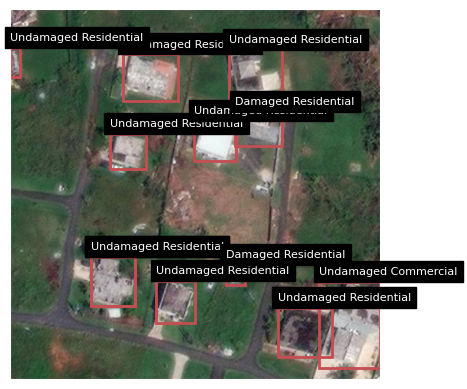

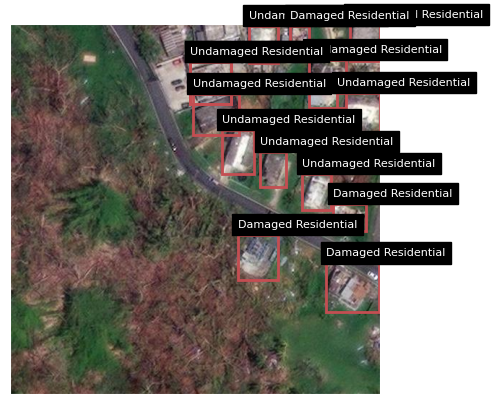

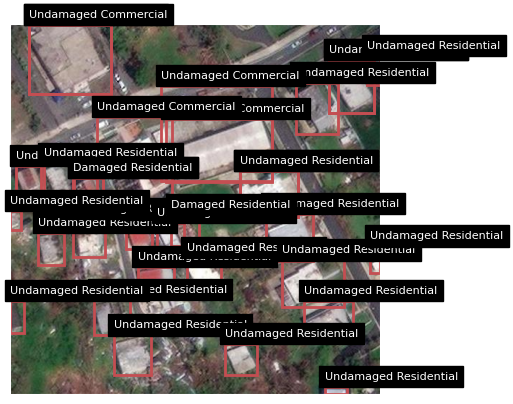

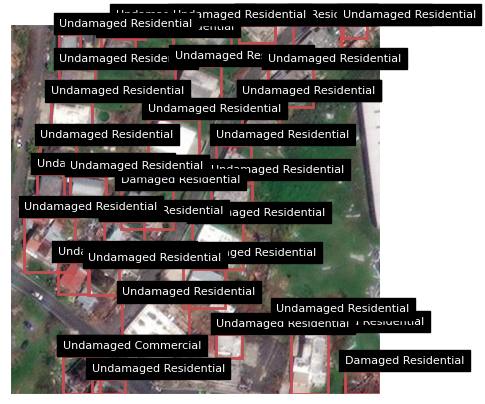

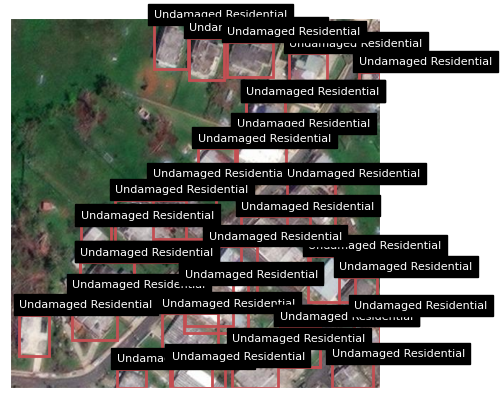

In [97]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

def display_image_with_boxes(image_path, detections):
    img = Image.open(image_path)
    fig, ax = plt.subplots(1)
    ax.imshow(img)
    ax.grid(False)  # Disable gridlines
    ax.set_xticks([])  # Remove x-axis tick marks
    ax.set_yticks([])  # Remove y-axis tick marks

    for det in detections:
        rect = patches.Rectangle((det['x_min'], det['y_min']), det['x_max'] - det['x_min'], det['y_max'] - det['y_min'],
                                 linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        ax.text(det['x_min'], det['y_min'] - 10, det['class_name'], 
                color='white', fontsize=8, backgroundcolor='black')

    plt.show()

# Display results for the first few images using the updated function
for file_path in bda_image_files[:5]:  # Assume you want to display for the first 5 images
    relevant_detections = [det for det in merged_predictions if det['image_path'] == file_path]
    display_image_with_boxes(file_path, relevant_detections)

# Evaluate